# Deep Learning

## 1. Montar o Google Drive
## 2. Transfer Learning ("Transferência de Aprendizado")
## 3. Data Augmentation ("Aumentação de Dados")
## 4. Fine Tuning ("Ajuste Fino")




# 1. Montar o Google Drive

In [ ]:
# 1. Montar o Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Transfer Learning ("Transferência de Aprendizado")

Transfer Learning (ou “Transferência de Aprendizado”) é uma técnica poderosa em aprendizado de máquina que permite reaproveitar o conhecimento de um modelo já treinado em uma tarefa ampla (como classificação de imagens no ImageNet) para resolver uma nova tarefa específica com menos dados e menos tempo de treinamento.

📊 Quando usar Transfer Learning:
- Quando seu dataset é pequeno ou difícil de rotular

- Quando você quer resultados rápidos e confiáveis

- Quando sua tarefa é semelhante à do modelo original (ex: imagens naturais)




# 2.1. 🔧 Aplicação prática com TensorFlow/Keras

In [ ]:
# 2. Importações

import matplotlib
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

# 2.2. Construir um gráfico que plota e salva o histórico de treinamento

In [ ]:
# 2.2. Construir um gráfico que plota e salva o histórico de treinamento

def plot_training(H, N, plotPath):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Treinamento Perda (Loss) e Acurácia (Accuracy)")
    plt.xlabel("Épocas #")
    plt.ylabel("Perda (Loss)/Acurácia (Accuracy)")
    plt.legend(loc="upper right")
    plt.savefig(plotPath)

# 2.2. Caminho do dataset

In [ ]:
# 2.2. Caminho do dataset

drive_path = '/content/drive/My Drive/FarmTechVision_Grupo7/dataset/images/'



# 2.3. Derivar os caminhos para o treinamento, validação e teste

In [ ]:
# 2.3. Derivar os caminhos para o treinamento, validação e teste
# 2.3.1 Diretórios
train_path = os.path.sep.join(['/content/drive/My Drive/FarmTechVision_Grupo7/dataset/', 'images', 'train'])
val_path = os.path.sep.join(['/content/drive/My Drive/FarmTechVision_Grupo7/dataset/', 'images', 'val'])
test_path = os.path.sep.join(['/content/drive/My Drive/FarmTechVision_Grupo7/dataset/','images', 'test'])

# 2.3.2 Determinar o número total de caminhos de imagem nos diretórios de treinamento, validação e teste
num_train = len(list(paths.list_images(train_path)))
num_val = len(list(paths.list_images(val_path)))
num_test = len(list(paths.list_images(test_path)))

# 2.4. Define o tamanho do lote (batch) de imagens que será processado a cada passo do treinamento

# - 32 é um valor padrão amplamente usado por equilibrar desempenho e estabilidade

In [ ]:
# 2.4. Define o tamanho do lote (batch) de imagens que será processado a cada passo do treinamento
# - 32 é um valor padrão amplamente usado por equilibrar desempenho e estabilidade
BATCH_SIZE = 32

# 2.4.1. Lista com os nomes das classes que o modelo deve aprender a classificar
CLASSES = ["bike", "cat"]

# 3. Data Augmentation ("Aumentação de Dados")

Data Augmentation (ou Aumentação de Dados) é uma técnica essencial em visão computacional que consiste em gerar variações artificiais das imagens do seu conjunto de dados para aumentar sua diversidade sem precisar coletar novas imagens. Isso ajuda a evitar overfitting e melhora a capacidade de generalização do modelo.


🎯 Por que usar Data Augmentation:
- Reduz overfitting: o modelo não memoriza os dados, aprende padrões mais robustos.

- Simula variações reais: como rotação, iluminação, escala, ruído.

- Aumenta o tamanho efetivo do dataset: útil quando há poucos exemplos.

# 3.1. Inicializar o objeto de aumento de dados de treinamento

In [ ]:
# 3.1.1 Inicializar o objeto de aumento de dados de treinamento
train_aug = ImageDataGenerator(rotation_range=30,
                              zoom_range=0.15,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.15,
                              horizontal_flip=True,
                              fill_mode="nearest")

# 3.1.2 Inicializar o objeto de aumento de dados de validação/teste (ao qual adicionaremos a subtração da média)
val_aug = ImageDataGenerator()

# 3.1.3 Definir a subtração média do ImageNet (em ordem RGB) e definir o valor da subtração média para cada um dos objetos de aumento de dados
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
train_aug.mean = mean
val_aug.mean = mean

# 3.1.4. Inicializar o gerador de treinamento
train_gen = train_aug.flow_from_directory(train_path,
                                        class_mode="categorical",
                                        target_size=(224, 224),
                                        color_mode="rgb",
                                        shuffle=True,
                                        batch_size=BATCH_SIZE)

# 3.1.5 Inicializar o gerador de validação
val_gen = val_aug.flow_from_directory(val_path,
                                    class_mode="categorical",
                                    target_size=(224, 224),
                                    color_mode="rgb",
                                    shuffle=False,
                                    batch_size=BATCH_SIZE)

# 3.1.6 Inicializar o gerador de testes
test_gen = val_aug.flow_from_directory(test_path,
                                     class_mode="categorical",
                                     target_size=(224, 224),
                                     color_mode="rgb",
                                     shuffle=False,
                                     batch_size=BATCH_SIZE)

Found 66 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


 # 3.2. Obter o próximo lote de dados gerado pelo ImageDataGenerator no Keras

In [ ]:
 # 3.2. Obter o próximo lote de dados gerado pelo ImageDataGenerator no Keras
 next(train_gen)

(array([[[[216.       , 216.       , 216.       ],
          [216.       , 216.       , 216.       ],
          [216.       , 216.       , 216.       ],
          ...,
          [216.       , 216.       , 216.       ],
          [216.       , 216.       , 216.       ],
          [216.       , 216.       , 216.       ]],
 
         [[215.5651   , 215.5651   , 215.5651   ],
          [216.       , 216.       , 216.       ],
          [216.       , 216.       , 216.       ],
          ...,
          [216.       , 216.       , 216.       ],
          [216.       , 216.       , 216.       ],
          [216.35536  , 216.35536  , 216.35536  ]],
 
         [[215.06729  , 215.06729  , 215.06729  ],
          [215.82024  , 215.82024  , 215.82024  ],
          [216.       , 216.       , 216.       ],
          ...,
          [216.4579   , 216.4579   , 216.4579   ],
          [216.86722  , 216.86722  , 216.86722  ],
          [217.       , 217.       , 217.       ]],
 
         ...,
 
         [[2

# 3.3. Acessar o formato (shape) do lote de imagens gerado pelo ImageDataGenerator no Keras
# - 32 imagens no lote
# - Cada imagem tem 224x224 pixels
# - 3 canais de cor (RGB)

In [ ]:
# 3.3. Acessar o formato (shape) do lote de imagens gerado pelo ImageDataGenerator no Keras
# 32 imagens no lote
# Cada imagem tem 224x224 pixels
# 3 canais de cor (RGB)
next(train_gen)[0].shape

(32, 224, 224, 3)

# 3.4. Gerador de dados criado com ImageDataGenerator.flow_from_directory()
# Exibe a imagem usando o Matplotlib

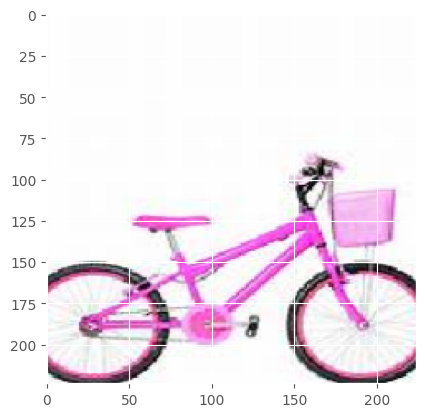

In [ ]:
# 3.4. Gerador de dados criado com ImageDataGenerator.flow_from_directory()
# Exibe a imagem usando o Matplotlib
image = next(train_gen)[0][0]
plt.imshow(image.astype(int))

# 3.5. Carregar a rede VGG16, garantindo que os conjuntos de camadas FC principais sejam deixados desligado

In [ ]:
# 3.5. carregar a rede VGG16, garantindo que os conjuntos de camadas FC principais sejam deixados desligado
base_model = VGG16(weights="imagenet",
                  include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))

# 3.5.1. Construir a cabeça do modelo que será colocada em cima do modelo base
head_model = base_model.output
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(512, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(len(CLASSES), activation="softmax")(head_model)

# 3.5.2. Coloque o modelo FC principal em cima do modelo base (este se tornará o modelo real que treinaremos)
model = Model(inputs=base_model.input, outputs=head_model)

# 3.6. Faça um loop em todas as camadas do modelo base e congele-as para que *não* sejam atualizadas durante o primeiro processo de treinamento

In [ ]:
# Faça um loop em todas as camadas do modelo base e congele-as para que *não* sejam atualizadas durante o primeiro processo de treinamento
for layer in base_model.layers:
    layer.trainable = False

# 3.7. Compilar nosso modelo (isso precisa ser feito depois de definirmos nossas camadas como não treináveis)

In [ ]:
# 3.7. compilar nosso modelo (isso precisa ser feito depois de definirmos nossas camadas como não treináveis
print("[INFO] compiling model...")
opt = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

# 3.7.1. Treinar a cabeça da rede por algumas épocas (todas as outras camadas são congeladas)
# Isso permitirá que as novas camadas FC comecem a ser inicializadas com valores "Aprendidos" reais em vez de valores aleatórios puros
print("[INFO] training head...")
H = model.fit(train_gen,
              validation_data=val_gen,
              epochs=50)

[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5376 - loss: 11.9750 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step - accuracy: 0.9545 - loss: 1.3226 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step - accuracy: 0.9924 - loss: 0.0311 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - accuracy: 0.9851 - loss: 0.3276 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step - accuracy: 0.9924 - loss: 0.0072 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step - accuracy: 1.0000 - loss: 0.0000e

# 3.8. Reinicie o gerador de testes e avalie a rede após o ajuste fino apenas do cabeçote da rede

[INFO] evaluating after fine-tuning network head...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
              precision    recall  f1-score   support

        bike       1.00      1.00      1.00         4
         cat       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



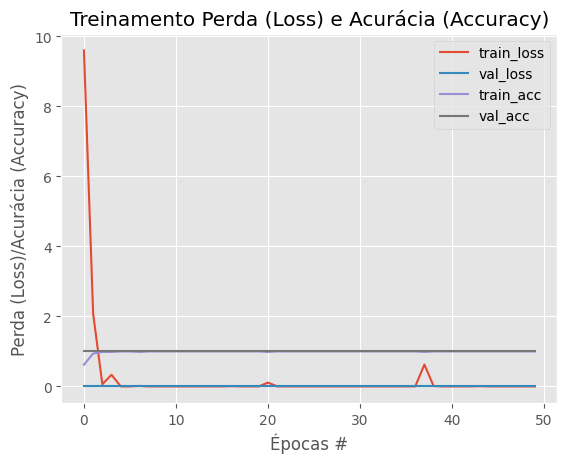

In [ ]:
# 3.8. Reinicie o gerador de testes e avalie a rede após o ajuste fino apenas do cabeçote da rede
print("[INFO] evaluating after fine-tuning network head...")
test_gen.reset()
pred_indices = model.predict(test_gen, steps=(num_test // BATCH_SIZE) + 1)
pred_indices = np.argmax(pred_indices, axis=1)
print(classification_report(test_gen.classes, pred_indices, target_names=test_gen.class_indices.keys()))
plot_training(H, 50, 'warmup.png')

# Redefinir nossos geradores de dados
train_gen.reset()
val_gen.reset()

# 4. Fine Tuning ("Ajuste Fino")

Fine Tuning (ou “Ajuste Fino”) é uma técnica avançada dentro do Transfer Learning que permite refinar um modelo pré-treinado para uma tarefa específica. Em vez de treinar uma rede do zero, você aproveita o conhecimento aprendido em um grande conjunto de dados (como o ImageNet) e ajusta parte da rede para se adaptar ao seu problema.

🧠 Por que usar Fine Tuning:
- Aproveita pesos já treinados: acelera o aprendizado e melhora a performance.

- Adapta o modelo ao seu domínio: útil quando seu dataset é diferente do original.

- Evita overfitting: ao congelar partes da rede, você reduz o risco de superajuste.


# 4.1. Agora que as camadas FC principais foram treinadas/inicializadas, vamos descongelar o conjunto final de camadas CONV e torná-las treináveis

In [ ]:
# 4.1. Agora que as camadas FC principais foram treinadas/inicializadas, vamos descongelar o conjunto final de camadas CONV e torná-las treináveis
for layer in base_model.layers[15:]:
    layer.trainable = True

# Faça um loop sobre as camadas do modelo e mostre quais são treináveis ​​ou não
for layer in base_model.layers:
    print("{}: {}".format(layer, layer.trainable))

<InputLayer name=input_layer_5, built=True>: False
<Conv2D name=block1_conv1, built=True>: False
<Conv2D name=block1_conv2, built=True>: False
<MaxPooling2D name=block1_pool, built=True>: False
<Conv2D name=block2_conv1, built=True>: False
<Conv2D name=block2_conv2, built=True>: False
<MaxPooling2D name=block2_pool, built=True>: False
<Conv2D name=block3_conv1, built=True>: False
<Conv2D name=block3_conv2, built=True>: False
<Conv2D name=block3_conv3, built=True>: False
<MaxPooling2D name=block3_pool, built=True>: False
<Conv2D name=block4_conv1, built=True>: False
<Conv2D name=block4_conv2, built=True>: False
<Conv2D name=block4_conv3, built=True>: False
<MaxPooling2D name=block4_pool, built=True>: False
<Conv2D name=block5_conv1, built=True>: True
<Conv2D name=block5_conv2, built=True>: True
<Conv2D name=block5_conv3, built=True>: True
<MaxPooling2D name=block5_pool, built=True>: True


# 4.2. Para que as alterações no modelo tenham efeito, precisamos recompilar o modelo, desta vez usando SGD com uma taxa de aprendizado *muito* pequena

In [ ]:
# 4.2. Para que as alterações no modelo tenham efeito, precisamos recompilar o modelo, desta vez usando SGD com uma taxa de aprendizado *muito* pequena
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

# Treinar o modelo novamente, desta vez ajustando *ambos* o conjunto final de camadas CONV junto com nosso conjunto de camadas FC
H = model.fit(train_gen,
              validation_data=val_gen,
              epochs=20)

[INFO] re-compiling model...
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step - accuracy: 1.0000 - loss: 2.7601e-08 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step - accuracy: 0.9807 - loss: 0.3340 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 3

# 4.3. Redefina o gerador de testes e use nosso modelo treinado para fazer previsões sobre os dados

[INFO] evaluating after fine-tuning network...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
              precision    recall  f1-score   support

        bike       1.00      1.00      1.00         4
         cat       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



[INFO] serializing network...


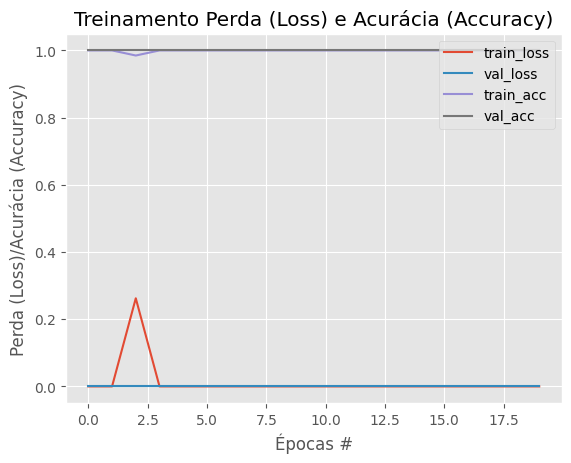

In [ ]:
# 4.3. Redefina o gerador de testes e use nosso modelo treinado para fazer previsões sobre os dados
print("[INFO] evaluating after fine-tuning network...")
test_gen.reset()
pred_indices = model.predict(test_gen, steps=(num_test // BATCH_SIZE) + 1)
pred_indices = np.argmax(pred_indices, axis=1)
print(classification_report(test_gen.classes, pred_indices, target_names=test_gen.class_indices.keys()))
plot_training(H, 20, "unfrozen.png")

# Serializar o modelo para o disco
print("[INFO] serializing network...")
model.save('food11_model.hdf5')